In [1]:
# inport statements

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.linear_model import LinearRegression as LR
from sklearn.neighbors import KNeighborsRegressor as KNR
from xgboost import XGBRegressor as XGBR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [2]:
# uncomment lines below to generate labeled_data.csv and unlabeled_data.csv files

# data = pd.read_csv('elasticsearch-seed.csv')

# features_name = ['BathsTotal', 'BedsTotal', 'CDOM', 'LotSizeAreaSQFT', 'SqFtTotal', 'ElementarySchoolName']
# target_name = 'ClosePrice'

# labeled_data = data.loc[~data['ClosePrice'].isna()]
# unlabeled_data = data.loc[data['ClosePrice'].isna()].drop(columns='ClosePrice')
# labeled_data = labeled_data[features_name + [target_name]]
# unlabeled_data = unlabeled_data[features_name]

# labeled_data.to_csv('labeled_data.csv', index=False)
# unlabeled_data.to_csv('unlabeled_data.csv', index=False)

In [3]:
# read data
labeled_data = pd.read_csv('labeled_data.csv')
unlabeled_data = pd.read_csv('unlabeled_data.csv')

print(f'labeled data shape {labeled_data.shape}')
print(f'unlabeled data shape {unlabeled_data.shape}')

labeled data shape (223, 7)
unlabeled data shape (430, 6)


In [4]:
# We want to group ElementarySchoolName values regarding the mean ClosePrice
def get_school_group(price):
    if np.isnan(price):
        group = 5
    else:
        group = min(max((price // 100000) - 2, 0), 4)
    return f'group_{group:.0f}'

data = pd.concat((labeled_data, unlabeled_data), axis=0)
price_per_school = data[['ElementarySchoolName', 'ClosePrice']].groupby(by='ElementarySchoolName').mean().reset_index()
price_per_school['group'] = price_per_school['ClosePrice'].map(get_school_group)
schools_groups_map = dict(price_per_school[['ElementarySchoolName', 'group']].to_numpy())

In [5]:
labeled_data['ElementarySchoolName'] = labeled_data['ElementarySchoolName'].map(lambda x: schools_groups_map[x])
unlabeled_data['ElementarySchoolName'] = unlabeled_data['ElementarySchoolName'].map(lambda x: schools_groups_map[x])

In [6]:
labeled_data

,BathsTotal,BedsTotal,CDOM,LotSizeAreaSQFT,SqFtTotal,ElementarySchoolName,ClosePrice
0,3.0,4,52,7100.28,2484,group_2,485000.0
1,2.1,4,58,8712.00,2631,group_1,330000.0
2,1.1,1,38,1306.80,884,group_1,185000.0
3,2.0,3,11,6969.60,1451,group_0,210000.0
4,2.0,3,89,6098.40,1559,group_1,225000.0
...,...,...,...,...,...,...,...
218,4.1,4,39,12153.24,4758,group_2,950000.0
219,4.1,4,58,16465.68,4140,group_4,970000.0
220,4.2,5,166,11717.64,7891,group_2,1225000.0
221,4.1,5,16,23565.96,5805,group_4,1485000.0


In [7]:
target_name = 'ClosePrice'

# get each columns by type
categorical_features = unlabeled_data.select_dtypes('object').columns
numerical_features = unlabeled_data.select_dtypes(['int64', 'float64']).columns

In [8]:
data = pd.concat((labeled_data[unlabeled_data.columns], unlabeled_data), axis=0)

# dummy categorical features
data = pd.get_dummies(data, drop_first=True)
labeled_data = pd.concat((data.iloc[:labeled_data.shape[0],:], labeled_data[target_name]), axis=1)
unlabeled_data = data.iloc[labeled_data.shape[0]:,:]

# scale numerical features
scaler = MinMaxScaler()
scaler.fit(data[numerical_features])
labeled_data[numerical_features] = scaler.transform(labeled_data[numerical_features])
unlabeled_data[numerical_features] = scaler.transform(unlabeled_data[numerical_features])

In [9]:
labels = labeled_data['ClosePrice'].to_numpy()
features = labeled_data.drop(columns='ClosePrice').to_numpy()

In [10]:
def plot_predictions_vs_actual(labels, predictions):
    plt.scatter(labels, predictions)
    plt.xlabel('true prices')
    plt.ylabel('predicted prices')
    plt.title('true prices vs predicted prices')

# Random Forest

In [11]:
rf = RF()
scores = cross_validate(rf, features, labels, return_train_score=True, scoring='neg_mean_absolute_error')

print(f"train mean absolute error = {-scores['train_score'].mean()}")
print(f"test mean absolute error = {-scores['test_score'].mean()}")

train mean absolute error = 17839.440817776664
test mean absolute error = 90605.89770909092


In [12]:
# cross validation and model fitting

rf.fit(features, labels)
print(f'r² score = {rf.score(features, labels)}')
print(f'rmse = {np.sqrt(mse(labels, rf.predict(features)))}')
print(f'mae = {mae(labels, rf.predict(features))}')

r² score = 0.973163599977845
rmse = 32262.2077894996
mae = 19269.994573991033


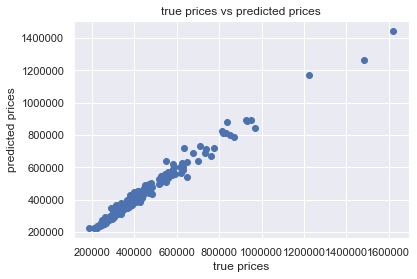

In [13]:
plot_predictions_vs_actual(labels, rf.predict(features))
plt.savefig('random_forest.png')

# Linear regression

In [14]:
lr = LR()
scores = cross_validate(lr, features, labels, return_train_score=True, scoring='neg_mean_absolute_error')

print(f"train mean absolute error = {-scores['train_score'].mean()}")
print(f"test mean absolute error = {-scores['test_score'].mean()}")

train mean absolute error = 56124.246565932015
test mean absolute error = 91167.6470978325


In [15]:
# cross validation and model fitting

lr.fit(features, labels)
lr.score(features, labels)
print(f'r² score = {lr.score(features, labels)}')
print(f'rmse = {np.sqrt(mse(labels, lr.predict(features)))}')
print(f'mae = {mae(labels, lr.predict(features))}')

r² score = 0.8170382695843789
rmse = 84238.78322894758
mae = 60010.959478057746


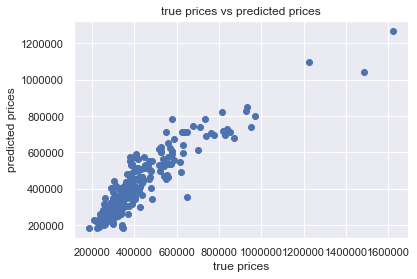

In [16]:
plot_predictions_vs_actual(labels, lr.predict(features))
plt.savefig('linear_regression.png')

# KNeighbors Regressor

In [17]:
knr = KNR()
scores = cross_validate(knr, features, labels, return_train_score=True, scoring='neg_mean_absolute_error')

print(f"train mean absolute error = {-scores['train_score'].mean()}")
print(f"test mean absolute error = {-scores['test_score'].mean()}")

train mean absolute error = 47753.96312346996
test mean absolute error = 103286.99931313131


In [18]:
# cross validation and model fitting

knr.fit(features, labels)
knr.score(features, labels)
print(f'r² score = {knr.score(features, labels)}')
print(f'rmse = {np.sqrt(mse(labels, knr.predict(features)))}')
print(f'mae = {mae(labels, knr.predict(features))}')

r² score = 0.8371431740319235
rmse = 79475.8055868656
mae = 48218.32914798206


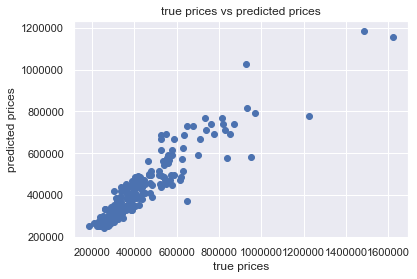

In [19]:
plot_predictions_vs_actual(labels, knr.predict(features))
plt.savefig('kneighbors.png')

# Gradient Boosted Trees Regressor

In [20]:
xgbr = XGBR()
scores = cross_validate(xgbr, features, labels, return_train_score=True, scoring='neg_mean_absolute_error')

print(f"train mean absolute error = {-scores['train_score'].mean()}")
print(f"test mean absolute error = {-scores['test_score'].mean()}")

[20:24:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:24:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:24:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:24:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:24:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train mean absolute error = 19967.82393672321
test mean absolute error = 91422.16144255051


In [21]:
# cross validation and model fitting

xgbr.fit(features, labels)
xgbr.score(features, labels)
print(f'r² score = {xgbr.score(features, labels)}')
print(f'rmse = {np.sqrt(mse(labels, xgbr.predict(features)))}')
print(f'mae = {mae(labels, xgbr.predict(features))}')

[20:24:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
r² score = 0.9751418878657215
rmse = 31050.316187311528
mae = 23064.461743273543


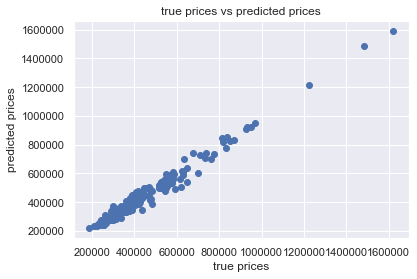

In [22]:
plot_predictions_vs_actual(labels, xgbr.predict(features))
plt.savefig('xgb.png')

In [23]:
# save predictions on unlabeled data

unlabeled_data_predictions = unlabeled_data.copy()
unlabeled_data_predictions['ClosePrice'] = xgbr.predict(unlabeled_data.to_numpy())
unlabeled_data_predictions.to_csv('unlabeled_data_predictions.csv', index=False)

In [24]:
from xgboost import XGBClassifier

m = XGBClassifier(
    max_depth=2,
    gamma=2,
    eta=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5
)
m.fit(features,labels)
m.score(features, labels)

print(f'r² score = {m.score(features, labels)}')
print(f'rmse = {np.sqrt(mse(labels, m.predict(features)))}')
print(f'mae = {mae(labels, m.predict(features))}')

r² score = 0.06726457399103139
rmse = 145976.94127696496
mae = 79092.12107623319
